In [1]:
import math
from pymongo import MongoClient
from xml.etree import ElementTree
import pprint
import json
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import numpy as np
import urllib.request, json

class electricFence():
    def __init__(self):
        self.latitude = []
        self.longitude = []
        self.location = []
        self.frequency = {}
        self.chosenPoint = []
        self.user = []
        
    def pullData(self, user): #pull latitude and longitude
        
        for x in user:
            self.user = user

            client = MongoClient('120.126.136.17',27017)
            db = client['Tracker']
            collection = db[x]
            cursor = collection.find({})

            jsonData = [d for d in cursor]

            for y in jsonData:
                self.latitude.append(float(y['latitude']))
                self.longitude.append(float(y['longitude']))
            
    def onlySanxia(self):
#         Too slow
        with open('geography.gml', encoding = 'utf8') as file:
            tree = ElementTree.parse(file)
            root = tree.getroot()
            for i in range(len(root)):
                if root[i][0][0].text == '新北市三峽區':
                    data = root[i][0][1][0][0][0][0][0][0].text
        data = data.split(' ')
        boardData = []
        for x in data:
            x = x.split(',')
            x[0] = float(x[0])
            x[1] = float(x[1])
            boardData.append([x[0],x[1]])
        borderPath = mplPath.Path(boardData)
        
        for x in range(len(self.latitude)):
            if borderPath.contains_points(np.array([[self.longitude[x], self.latitude[x]]])):       
                self.location.append([round(self.latitude[x],4), round(self.longitude[x],4)])
                
    def removeOutlier(self):
        #remove that the variance is too large
        trainingset = np.array(self.location)
        mean = np.mean(trainingset, axis=0)
        sd = np.std(trainingset, axis=0)
        final_list = [x for x in self.location if ((x[0] > mean[0] - 6 * sd[0])and(x[1] > mean[1] - 6 * sd[1]))]
        final_list = [x for x in final_list if ((x[0] < mean[0] + 6 * sd[0])and(x[1] < mean[1] + 6 * sd[1]))]       
        self.location = final_list
        
    def abDistance(a, b):# calculate a and b distance  a[a緯, a經], b[b緯, b經]
        """
        兩點間距離D(x1,y1,x2,y2)=r×acos(sin(x1) ×sin(x2)+cos(x1) ×cos(x2) ×cos(y1-y2))
        x,y是緯度，經度的弧度單位，r是地球半徑
        """
        op = math.pi/180
        r = 6378.39
        return r*math.acos(math.sin(a[0]*op) * math.sin(b[0]*op) + 
                           math.cos(a[0]*op) * math.cos(b[0]*op) * math.cos(a[1]*op-b[1]*op))
    
    #establish a dict to count how many duplicate location
#     def addFrequency(self):
#         for x in self.location:
#             if tuple(x) in self.frequency:
#                 self.frequency[tuple(x)] += 1
#             else:
#                 self.frequency[tuple(x)] = 1
                
    def chosePoint(self):#point without duplicate
        #map out a tuplelist that it`s element is tuple type
        tuplelist = list(map(tuple, self.location))
        self.chosenPoint = list(set(tuplelist))
        return self.chosenPoint
    
    #make the bounds
    def squareBounds(self,boundScale = 1):
        #checking boundScale
        if type(boundScale) != 'int':
            boundScale = int(boundScale)
        if boundScale < 1:
            boundScale = 1
        elif boundScale > 10:
            boundScale = 10
            
        downlat = 24.938590 
        leftlong = 121.360761
        toplat = 24.94884
        rightlong = 121.373937

        temptlist = [[round(x[0],4), round(x[1],4)] for x in self.location]

        squarefreq = {}
        #make out a dic that is the smallest boundScale = 1
        for i in range(int(round(0.01,4)*10000)):
            for j in range(int(round(0.01,4)*10000)):
                squarefreq[tuple([round(downlat + i/10000 ,4), round(leftlong + j/10000,4)])]=0

        for x in temptlist:
            if tuple(x) in squarefreq:
                #the way i think: use mod to divide into two group just like roundup
                if round((x[0] - downlat)*10000,0) % boundScale != 0:
                    #less or equal than boundScale/2 = the smaller on 
                    if round((x[0] - downlat)*10000,0)% boundScale <= boundScale/2:
                        x[0] -= (round((x[0] - downlat)*10000,0) % boundScale)/10000
                    else:
                        x[0] += (boundScale - (round((x[0] - downlat)*10000,0) % boundScale))
                    x[0] = round(x[0],4)
                if round((x[1] - leftlong)*10000,0) % boundScale != 0:
                    if round((x[0] - leftlong)*10000,0) % boundScale != 0:
                        x[1] -= (round((x[0] - leftlong)*10000,0) % boundScale)/10000
                    else:
                        x[1] += (boundScale - (round((x[0] - leftlong)*10000,0) % boundScale))
                    x[1] = round(x[1],4)
                if tuple(x) in squarefreq:
                    squarefreq[tuple(x)] += 1

        #divide into different percentage
        boundlist = []
        squarefreqMax = max(squarefreq.values())
        if squarefreqMax != 0:
            squarefreqMax = math.log10(max(squarefreq.values()))
        for k,values in squarefreq.items():
            key = list(k)
            if round((key[0] - downlat)*10000,0) % boundScale == 0:
                if round((key[1] - leftlong)*10000,0) % boundScale == 0:
                    lt = [round(key[0] + 0.00005*boundScale,5), round(key[1] - 0.00005*boundScale,5)]
                    rt = [round(key[0] + 0.00005*boundScale,5), round(key[1] + 0.00005*boundScale,5)]
                    rd = [round(key[0] - 0.00005*boundScale,5), round(key[1] + 0.00005*boundScale,5)]
                    ld = [round(key[0] - 0.00005*boundScale,5), round(key[1] - 0.00005*boundScale,5)]
                    precentage = 0
                    org_values = values
                    if values!=0:
                        values = math.log10(values)
                    if(values>=0)and(values<squarefreqMax/5):
                        precentage = 0
                    elif (values>=squarefreqMax/5)and(values<2*squarefreqMax/5):
                        precentage = 1
                    elif (values>=2*squarefreqMax/5)and(values<3*squarefreqMax/5):
                        precentage = 2
                    elif (values>=3*squarefreqMax/5)and(values<4*squarefreqMax/5):
                        precentage = 3
                    else:
                        precentage = 4
                    boundlist.append([lt,rt,rd,ld,precentage,org_values])
                    
        squarelen = int(math.sqrt(len(boundlist)))
        spacelist = []
        #imply from bottomleft to topright
        # temptlist.append(boundlist[0][3])
        # temptlist.append(boundlist[0][2])
        # temptlist.append(boundlist[0][0])
        # temptlist.append(boundlist[0][1])

        # temptlist.append(boundlist[0][3])
        # temptlist.append(boundlist[10][1])
        # temptlist.append(boundlist[1][3])
        # temptlist.append([boundlist[10][1][0],boundlist[1][3][1]])

        #imply from topright to bottomleft
        # temptlist.append(boundlist[squarelen*squarelen - 1][1])
        # temptlist.append(boundlist[squarelen*squarelen - 1][3])
        # temptlist.append(boundlist[squarelen*squarelen - 1][2])
        # temptlist.append(boundlist[squarelen*squarelen - 1][0])

        # temptlist.append(boundlist[squarelen*squarelen - 2][0])
        # temptlist.append(boundlist[squarelen*(squarelen-1) - 1][2])
        # temptlist.append([boundlist[squarelen*(squarelen-1) - 1][3][0],boundlist[squarelen*squarelen - 2][0][1]])
        for x in range(squarelen):
            temptlist = []
            temptlist.append(boundlist[0][3]) 
            temptlist.append(boundlist[x * squarelen][0])
            temptlist.append([boundlist[x * squarelen][0][0],boundlist[x][2][1]])
            temptlist.append(boundlist[x][2])
            spacelist.append(temptlist)

        for x in range(squarelen - 1):
            temptlist = []         
            temptlist.append(boundlist[squarelen*squarelen - 1][1])
            temptlist.append(boundlist[squarelen*squarelen - 1 - x][0])
            temptlist.append([boundlist[squarelen*(squarelen-x) - 1][3][0],boundlist[squarelen*squarelen - 1 - x][0][1]])
            temptlist.append(boundlist[squarelen*(squarelen-x) - 1][2])
            spacelist.append(temptlist)
            
        valuelist=[]
        for x in boundlist:
            if x[4] != 0:
                valuelist.append(x)
        valuelist = sorted(valuelist,key=lambda x: x[5],reverse=True)
        sortNum = 1
        newlist = []
        for x in valuelist:
            tempt = x[0:5]
            tempt.append(sortNum)
            sortNum += 1
            newlist.append(tempt)
        return spacelist,newlist 

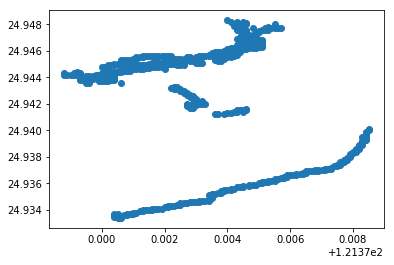

In [108]:
user = ['james']
elFence = electricFence()
elFence.pullData(user)
elFence.onlySanxia()
elFence.removeOutlier()
spacelist,valuelist = elFence.squareBounds()
lis = elFence.chosePoint()# == (lis = elFence.chosenPoint)


trainingset = np.array(lis)
plt.plot(trainingset[:,1], trainingset[:,0], 'o')
plt.show()

In [115]:
valuelist = sorted(valuelist,key=lambda x: x[5],reverse=True)
print(len(valuelist))
sortNum = 1
newlist = []
for x in valuelist:
    tempt = x[0:5]
    tempt.append(sortNum)
    sortNum += 1
    newlist.append(tempt)

69


69

In [116]:
newlist

[[[24.94385, 121.36935],
  [24.94385, 121.36945],
  [24.94375, 121.36945],
  [24.94375, 121.36935],
  4,
  1],
 [[24.94395, 121.36955],
  [24.94395, 121.36965],
  [24.94385, 121.36965],
  [24.94385, 121.36955],
  4,
  2],
 [[24.94395, 121.36935],
  [24.94395, 121.36945],
  [24.94385, 121.36945],
  [24.94385, 121.36935],
  3,
  3],
 [[24.94415, 121.36975],
  [24.94415, 121.36985],
  [24.94405, 121.36985],
  [24.94405, 121.36975],
  3,
  4],
 [[24.94435, 121.37005],
  [24.94435, 121.37015],
  [24.94425, 121.37015],
  [24.94425, 121.37005],
  3,
  5],
 [[24.94445, 121.37045],
  [24.94445, 121.37055],
  [24.94435, 121.37055],
  [24.94435, 121.37045],
  3,
  6],
 [[24.94405, 121.36945],
  [24.94405, 121.36955],
  [24.94395, 121.36955],
  [24.94395, 121.36945],
  3,
  7],
 [[24.94425, 121.36985],
  [24.94425, 121.36995],
  [24.94415, 121.36995],
  [24.94415, 121.36985],
  3,
  8],
 [[24.94445, 121.37025],
  [24.94445, 121.37035],
  [24.94435, 121.37035],
  [24.94435, 121.37025],
  3,
  9],
 